In [1]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT
from dstft.loss import kurtosis_loss
from dstft.optim import scale_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.Size([1, 6636]) cuda:0 torch.float32
[0, 1484, 2637, 3272, 3633, 5429, 6636]


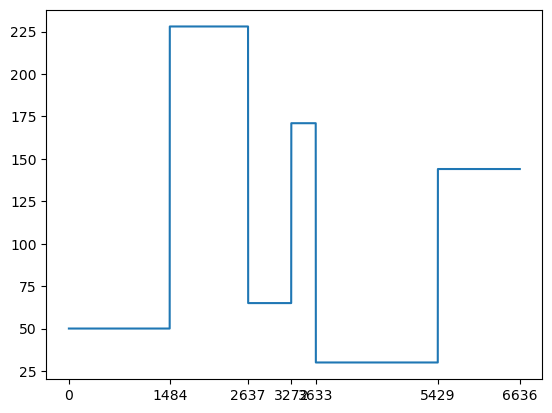

In [2]:
sr = 1e3
sizes = [1484, 1153, 635, 361, 1796, 1207]
freqs = [50, 228, 65, 171, 30, 144,]
f = freqs[0] * (torch.ones(sizes[0]) + .0 * torch.randn(sizes[0]))
for i in range(1, len(freqs)):
    f = torch.cat((f, freqs[i]  * (torch.ones(sizes[i]) + .0 * torch.randn(sizes[i]))))
f = f + 0. * torch.ones_like(f) * torch.randn_like(f)

x = torch.sin(2*pi*torch.cumsum(f, 0)/sr)
x += 0.2 * torch.randn(x.shape)
x = x[None, :].to(device)
print(x.shape, x.device, x.dtype)

mark_list = np.cumsum(sizes).tolist()
mark_list.insert(0, 0)
print(mark_list)

plt.figure()
plt.plot(f)
plt.xticks(mark_list)
plt.show()

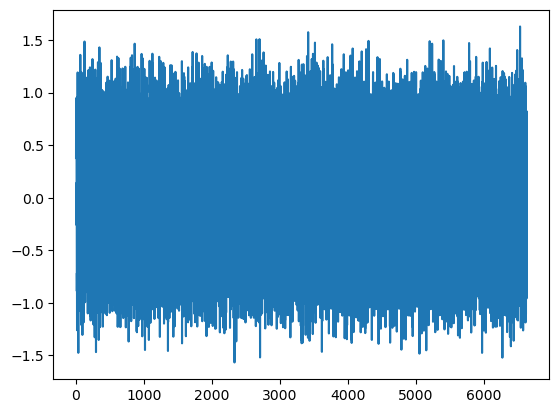

In [3]:
plt.figure()
plt.plot(x[0].cpu())
plt.show()

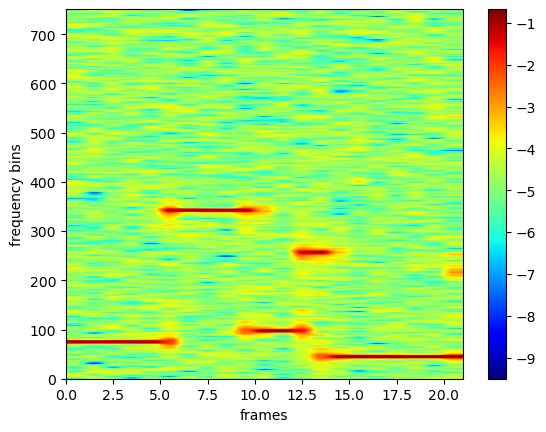

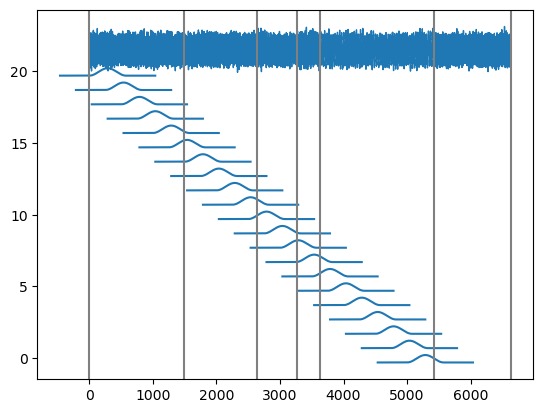

In [4]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=False, stride_requires_grad=False, win_p='t', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True, marklist=mark_list)

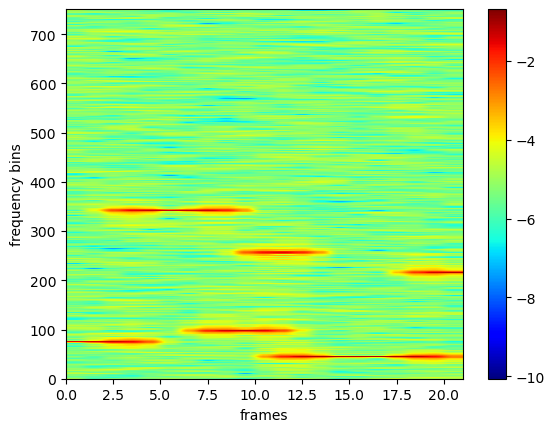

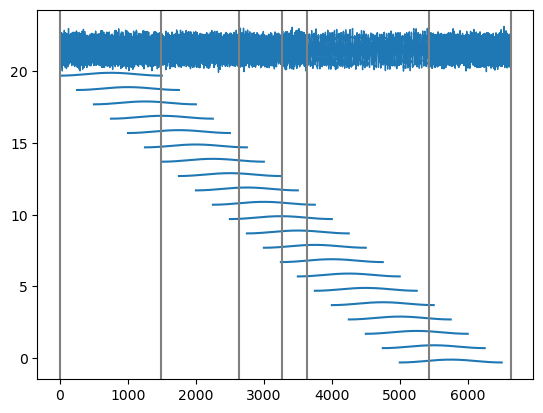

In [5]:
dstft = FDSTFT(x, win_length=1_500, support=1_500, stride=250, win_requires_grad=False, stride_requires_grad=False, win_p='t', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True, marklist=mark_list)

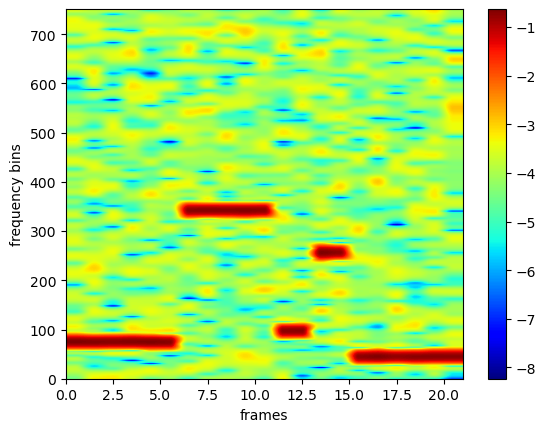

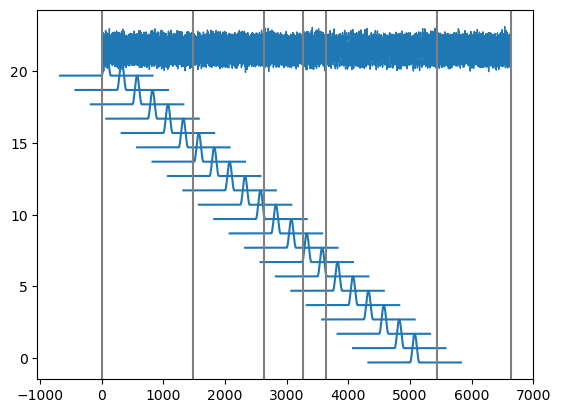

In [6]:
dstft = FDSTFT(x, win_length=150, support=1_500, stride=250, win_requires_grad=False, stride_requires_grad=False, win_p='t', stride_p=None, first_frame=True)
spec, *_ = dstft(x)
dstft.print(spec, x, weights=False, bar=True, marklist=mark_list)

Time-varying window length

Epoch 00444: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00454: reducing learning rate of group 0 to 4.0000e-02.
453


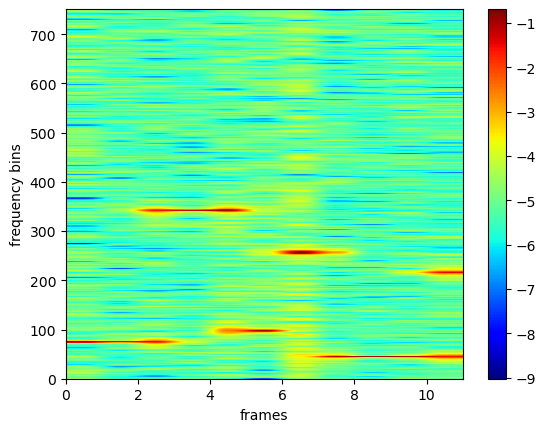

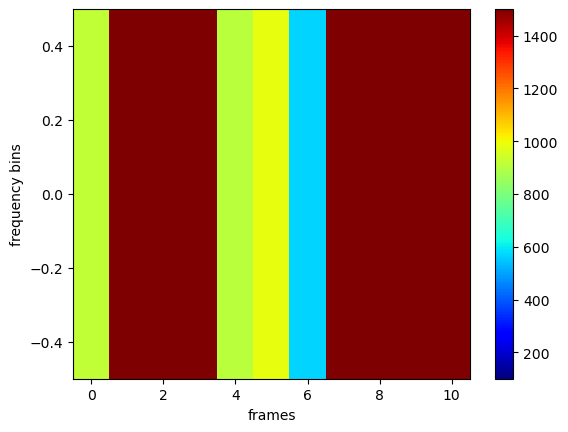

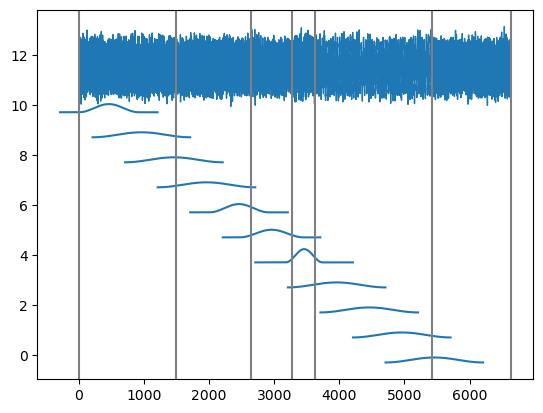

In [7]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.win_length, 'lr': 4.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00562: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00573: reducing learning rate of group 0 to 4.0000e-02.
572


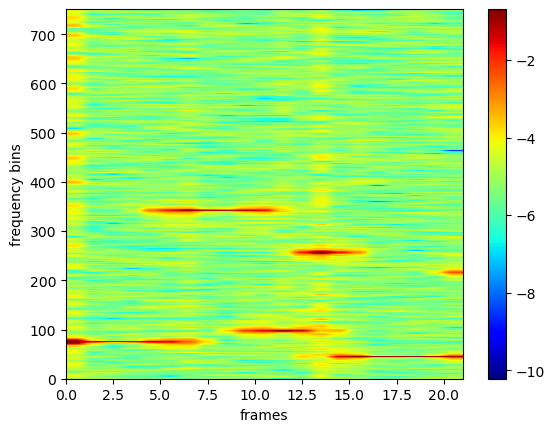

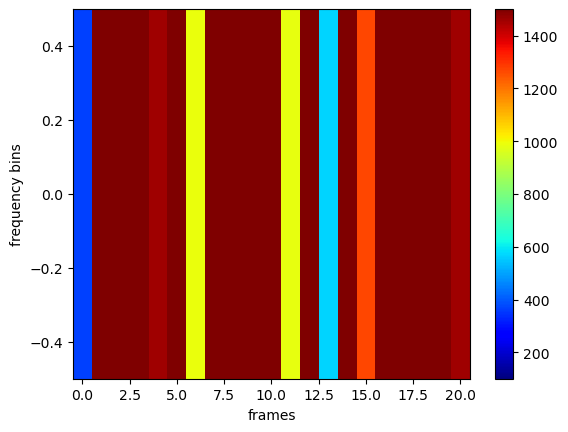

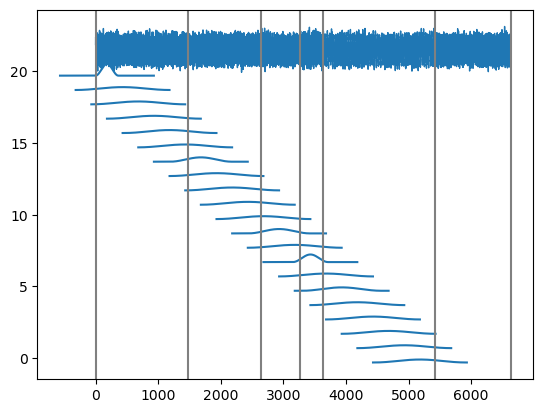

In [8]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.win_length, 'lr': 4.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

time-varying hop length

Epoch 00117: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00128: reducing learning rate of group 0 to 4.0000e-02.
127


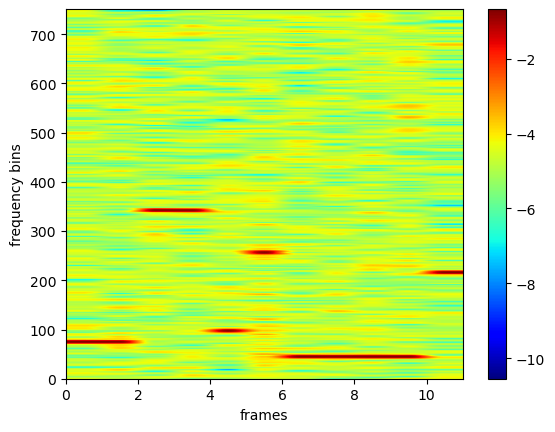

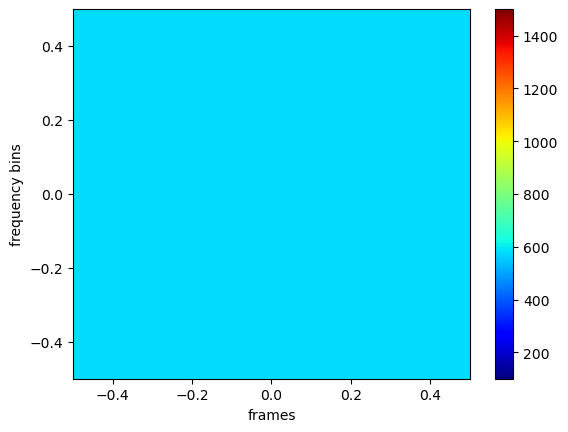

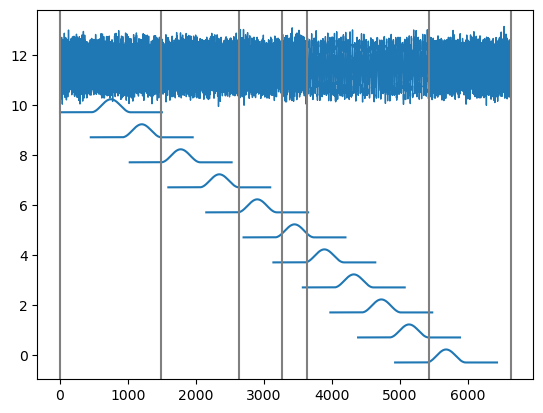

In [9]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=False, stride_requires_grad=True, win_p=None, stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 4.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()    
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00202: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00213: reducing learning rate of group 0 to 4.0000e-02.
212


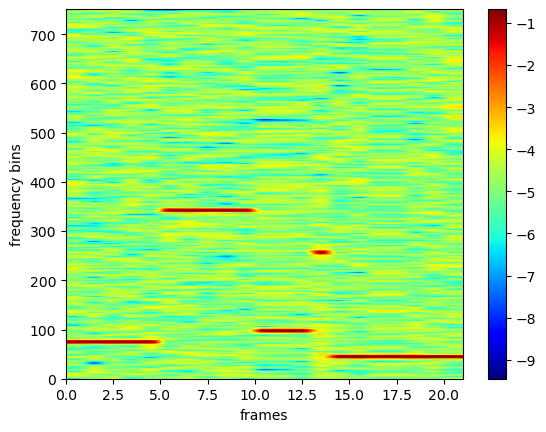

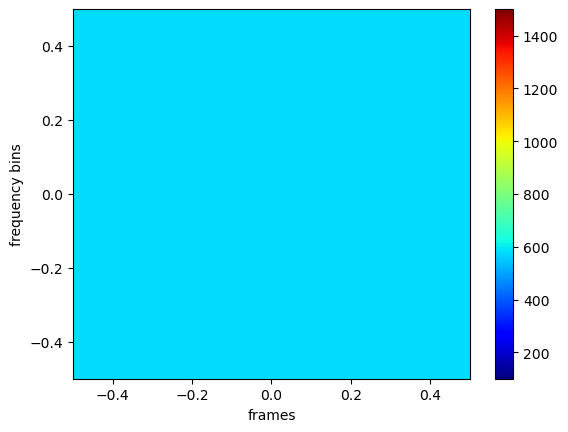

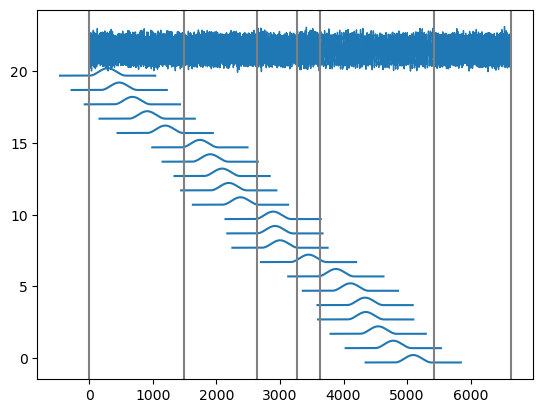

In [10]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=False, stride_requires_grad=True, win_p=None, stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(), 'lr': 4.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean() 
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Time-varying window and hop length

Epoch 00742: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00753: reducing learning rate of group 0 to 4.0000e-02.
752


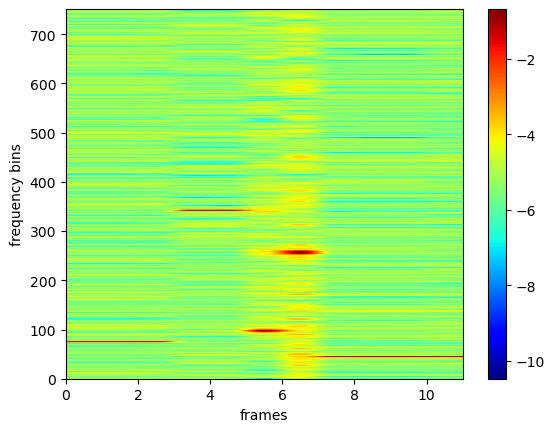

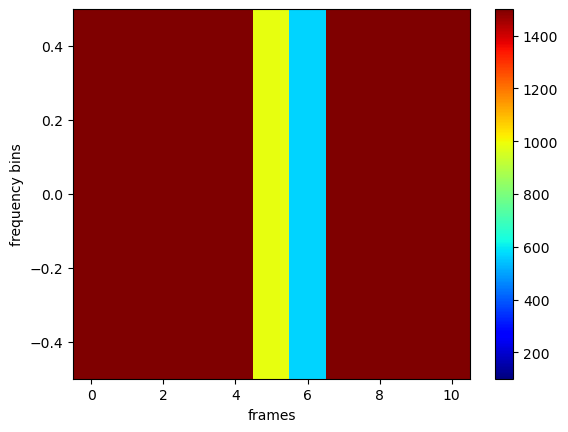

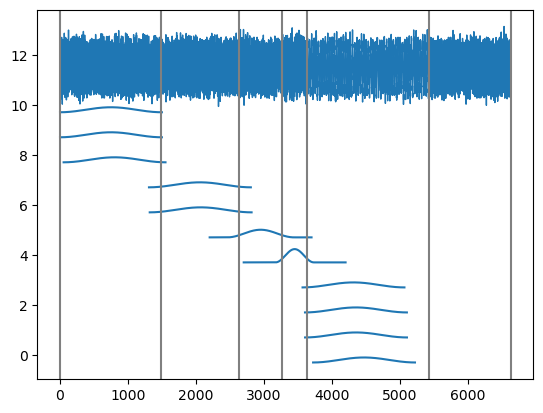

In [11]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00618: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00629: reducing learning rate of group 0 to 4.0000e-02.
628


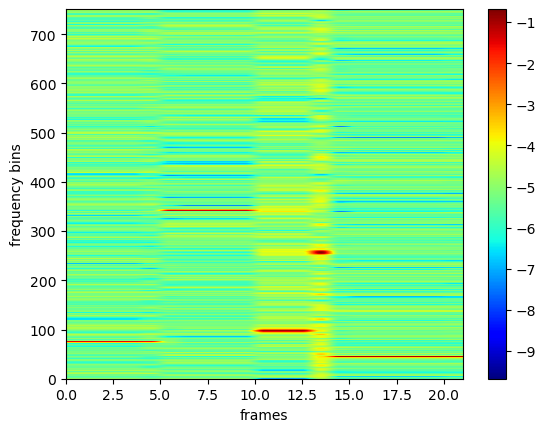

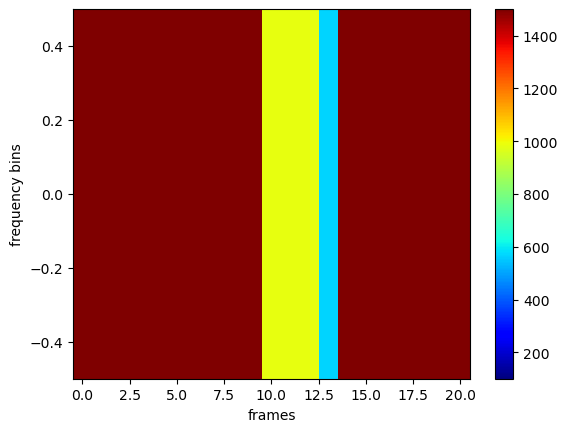

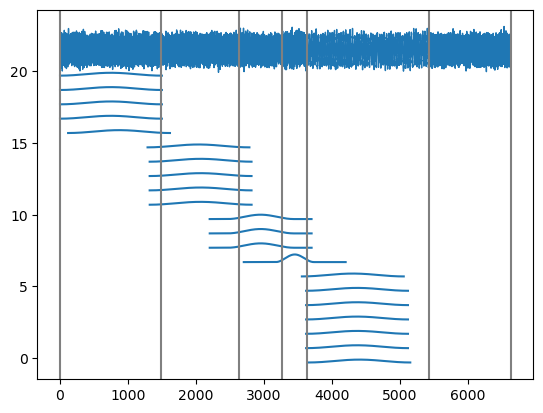

In [12]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Time-and-frequency varying window length and time-varying hop length

Epoch 00672: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00692: reducing learning rate of group 0 to 4.0000e-02.
691


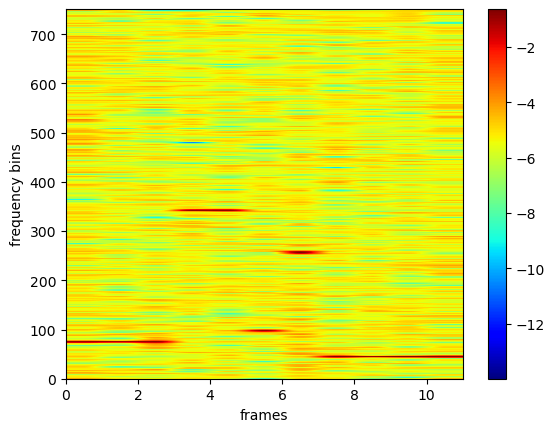

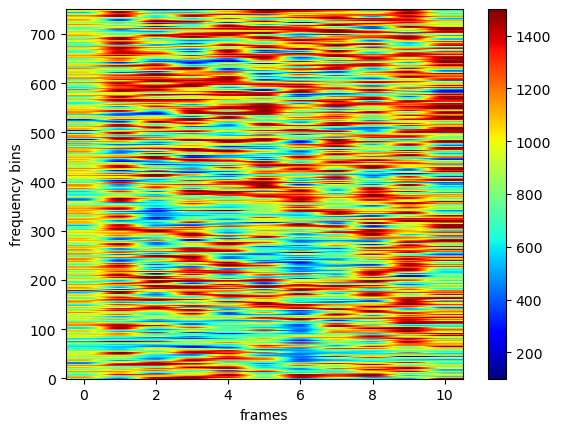

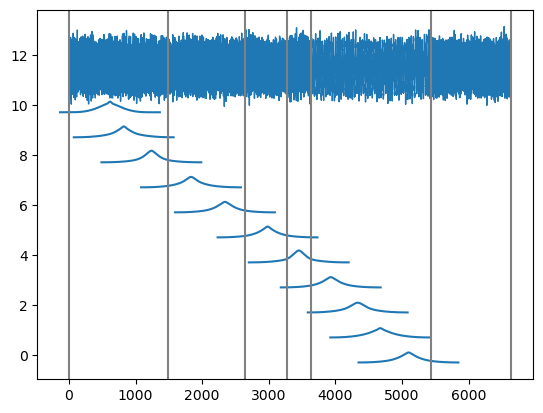

In [13]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(100_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 01468: reducing learning rate of group 0 to 4.0000e-01.
Epoch 01483: reducing learning rate of group 0 to 4.0000e-02.
1482


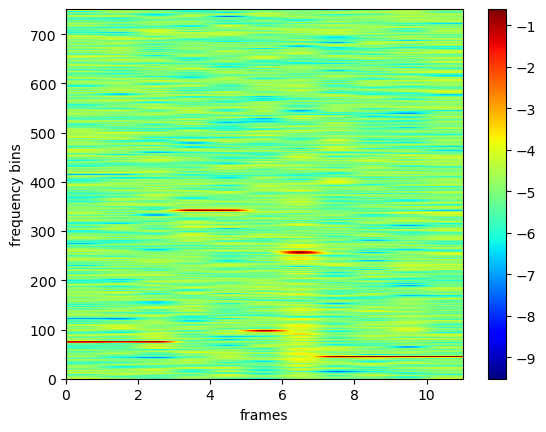

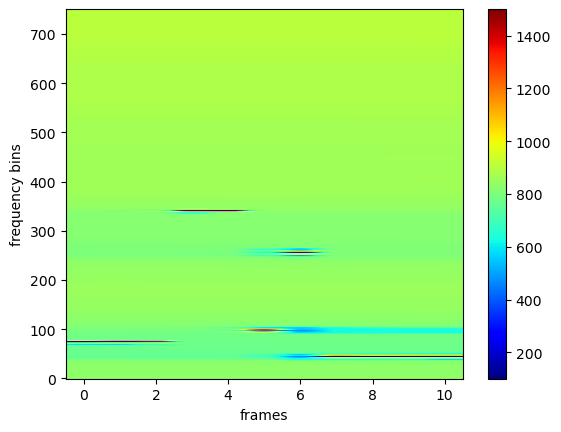

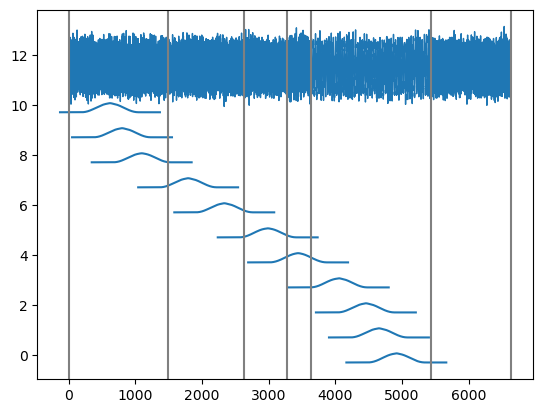

In [14]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(100_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean() + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 00581: reducing learning rate of group 0 to 4.0000e-01.
Epoch 00610: reducing learning rate of group 0 to 4.0000e-02.
609


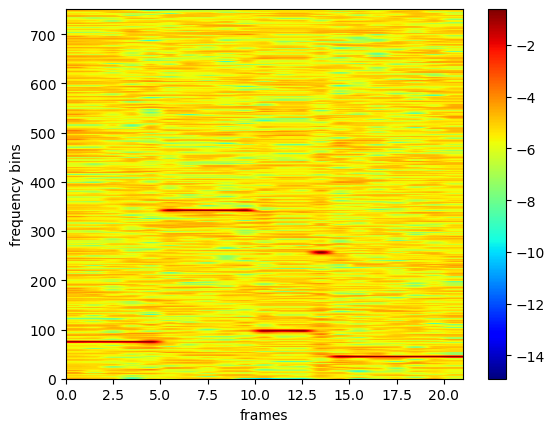

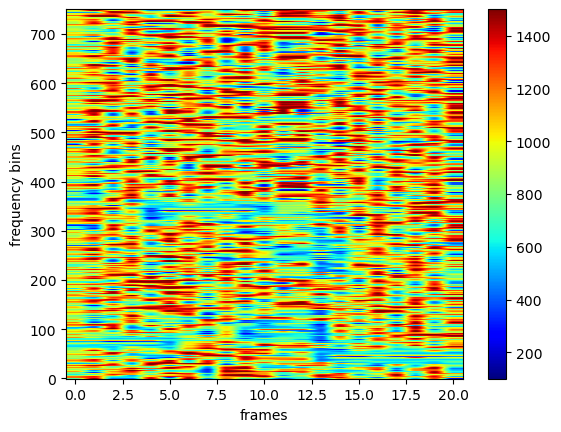

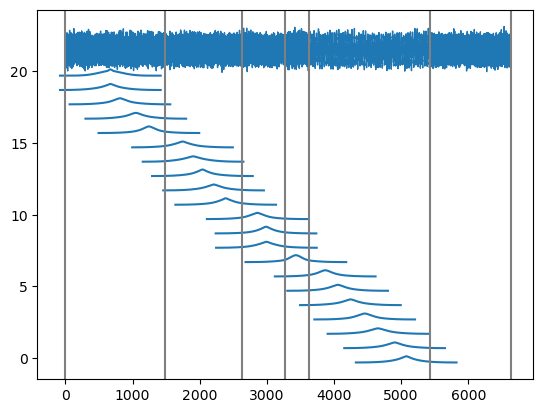

In [15]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Epoch 01384: reducing learning rate of group 0 to 4.0000e-01.
Epoch 01417: reducing learning rate of group 0 to 4.0000e-02.
1416


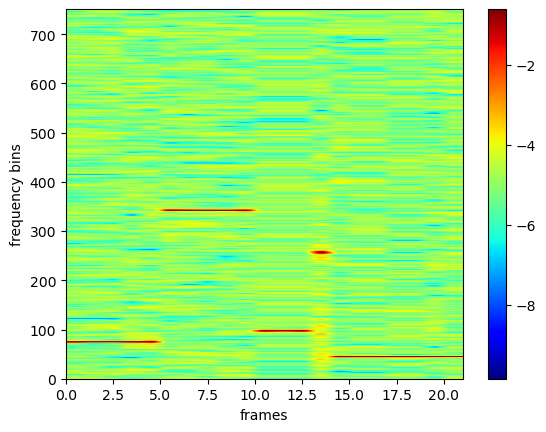

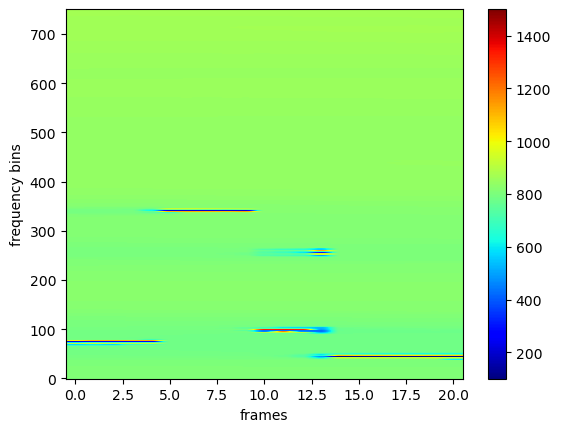

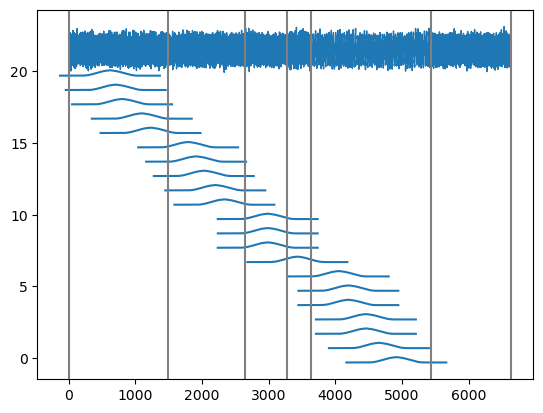

In [16]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100, first_frame=True)
params = [{'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()  + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Multi objective optimization

In [17]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100, first_frame=True)
params = [ {'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

def loss_kur(spec, dstft):
    return 1_000 * (1 / kurtosis_loss(spec)).mean()

def loss_cov(dstft):
    return 1_000 * (1 - dstft.coverage())

for epoch in range(10_000):
    scale = scale_loss(dstft, x, loss_kur, loss_cov)
    
    opt.zero_grad()    
    spec, *_ = dstft(x)
    loss1 = loss_kur(spec, dstft)
    loss2 = loss_cov(dstft)
    
    err = scale['loss1'] * loss1 + scale['loss2'] * loss2
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

KeyboardInterrupt: 

Epoch 00342: reducing learning rate of group 0 to 2.0000e+00.
Epoch 06582: reducing learning rate of group 0 to 1.0000e+00.
Epoch 06707: reducing learning rate of group 0 to 5.0000e-01.
6706


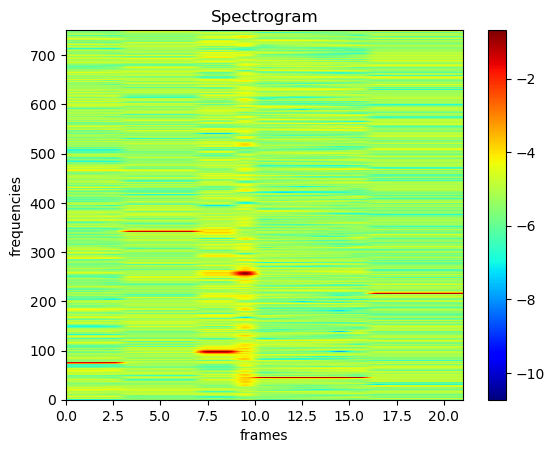

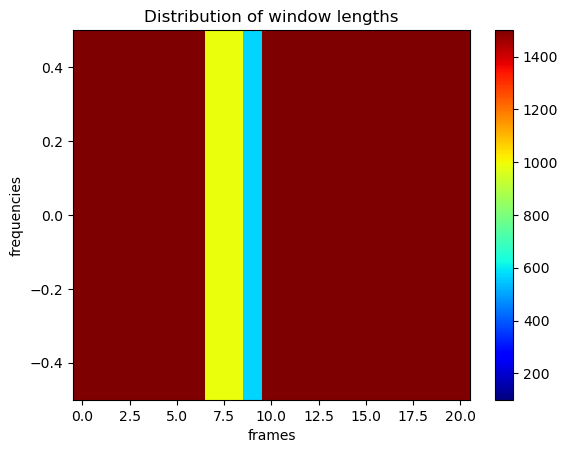

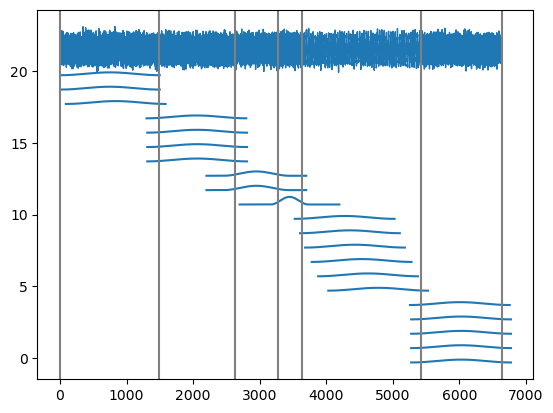

In [ ]:
dstft = FDSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [ {'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

def loss_kur(spec, dstft):
    return 1_000 * (1 / kurtosis_loss(spec)).mean()

def loss_cov(dstft):
    return 1_000 * (1 - dstft.coverage())

for epoch in range(10_000):
    scale = scale_loss(dstft, x, loss_kur, loss_cov)
    
    opt.zero_grad()    
    spec, *_ = dstft(x)
    loss1 = loss_kur(spec, dstft)
    loss2 = loss_cov(dstft)
    
    err = scale['loss1'] * loss1 + scale['loss2'] * loss2
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)